In [19]:
import polars as pl 
import polars.selectors as cs
import seaborn as sns
import utils
import get_data
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.manifold import TSNE
import itertools
import umap 
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, adjusted_mutual_info_score, mutual_info_score, adjusted_rand_score
import hdbscan

In [4]:
frame = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\stanford_sentiment.parquet")

In [5]:
kmeans = KMeans(n_clusters=2, random_state=2)
frame = frame.with_columns(
    pl.Series(
        name= 'clusters',
        values= kmeans.fit_predict(frame.select('embeddings').to_series().to_list())
    )
)

In [6]:
print('Rand Score (RS):                 ', rand_score(labels_true=frame.select('label').to_series().to_list(), labels_pred=frame.select('clusters').to_series().to_list()))
print('Adjusted Rand Score (ARS):       ', adjusted_rand_score(labels_true=frame.select('label').to_series().to_list(), labels_pred=frame.select('clusters').to_series().to_list()))
print('Adjusted Mutual Info Score (AMI):', adjusted_mutual_info_score(labels_true=frame.select('label').to_series().to_list(), labels_pred=frame.select('clusters').to_series().to_list()))
print('Mutual Info Score (MI):          ', mutual_info_score(labels_true=frame.select('label').to_series().to_list(), labels_pred=frame.select('clusters').to_series().to_list()))

Rand Score (RS):                  0.8613280876841903
Adjusted Rand Score (ARS):        0.7225892608139667
Adjusted Mutual Info Score (AMI): 0.6131630448257939
Mutual Info Score (MI):           0.4201820741688528


In [7]:
reducer = umap.UMAP()

In [8]:
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())

In [9]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))

In [23]:
umap_clusters = hdbscan.HDBSCAN().fit_predict(frame.select('reduced').to_series().to_list())

In [24]:
high_dimensional = hdbscan.HDBSCAN().fit_predict(frame.select('embeddings').to_series().to_list())

In [22]:
frame = frame.with_columns(pl.Series(name = 'umap_clusters', values = umap_clusters))

TypeError: Series constructor called with unsupported type 'HDBSCAN' for the `values` parameter

In [ ]:
frame = frame.with_columns(pl.Series(name = 'high_dimensional', values = high_dimensional))

<Axes: xlabel='field_0', ylabel='field_1'>

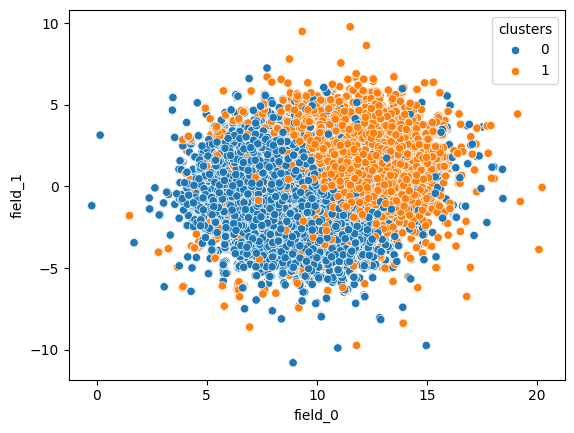

In [16]:
import seaborn as sns 

sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').to_pandas(), x = 'field_0', y = 'field_1', hue = 'clusters')

<Axes: xlabel='field_0', ylabel='field_1'>

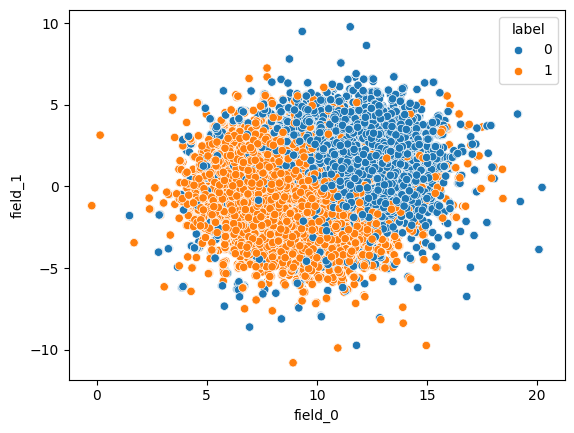

In [17]:
sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').to_pandas(), x = 'field_0', y = 'field_1', hue = 'label')